# Problem Set 1 - Neural Network Implementation

As described in section "3 Neural network implementation" of assignment 1, the goal is to build a Feed-forward Neural Network for classification using different approaches. To validate that your code is working and that the network is actually learning something, you can use the MNIST dataset. Finally, please submit proof of the learning progress as described in the assignment.

## Logistics
Team number: PS1 Group E <br>
Names: ,Kai Foerster <br>
Marticulation numbers: ,214288

## Imports

In [1]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from network_scratch import NeuralNetwork
from network_pytorch import NeuralNetworkTorch
from network_tensorflow import NeuralNetworkTf, TimeBasedLearningRate
import utils
import torchvision as tv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

tf.config.run_functions_eagerly(True)

In [2]:
# Automatically load changes in imported modules
%load_ext autoreload
%autoreload 2

# Explicitly set seed for reproducibility
GLOBAL_RANDOM_STATE = 42

random.seed(GLOBAL_RANDOM_STATE)
np.random.seed(GLOBAL_RANDOM_STATE)

## A) Neural Network Classifier from Scratch

### Data


In [3]:
# Download MNIST dataset
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, cache=True, as_frame=False)

# Preprocess dataset
x = (x / 255).astype('float32')
y = tf.keras.utils.to_categorical(y)

# Use only small subset of data for faster training
x = x[:1000]
y = y[:1000]

# Split data into train and validation set
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=GLOBAL_RANDOM_STATE)



c:\Users\kaius\.virtualenvs\ML_Lab_1_Group-A-YrkWYMVn\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


### ML Model & Training

In [4]:
# Copy pasted from network_scratch

class NeuralNetwork():
    def __init__(self, layer_shapes, epochs=50, learning_rate=0.01, random_state=1):

        #Define learning paradigms
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.random_state = random_state

        #Define network architecture: no. of layers and neurons
        #layer_shapes[i] is the shape of the input that gets multiplied 
        #to the weights for the layer (e.g. layer_shapes[0] is 
        #the number of input features)

        self.layer_shapes = layer_shapes
        self.weights = self._initialize_weights()

        #Initialize weight vectors calling the function
        #Initialize list of layer inputs before and after  
        #activation as lists of zeros.
        self.A = [None] * len(layer_shapes)
        self.Z = [None] * (len(layer_shapes)-1)

        #Define activation functions for the different layers
        self.activation_func = utils.sigmoid
        self.activation_func_deriv = utils.sigmoid_deriv
        self.output_func = utils.softmax
        self.output_func_deriv = utils.softmax_deriv
        self.cost_func = utils.mse
        self.cost_func_deriv = utils.mse_deriv




    def _initialize_weights(self):

        np.random.seed(self.random_state)
        self.weights = [] 

        for i in range(1, len(self.layer_shapes)):
            weight = np.random.rand(self.layer_shapes[i], self.layer_shapes[i-1]) - 0.5
            self.weights.append(weight)

        return self.weights


    def _forward_pass(self, x_train):
        '''
        TODO: Implement the forward propagation algorithm.
        The method should return the output of the network.
        '''
        self.A[0] = x_train
        for i in range(len(self.weights)):
            self.Z[i] = np.dot(self.weights[i], self.A[i])
            # Apply the correct activation function
            if i < len(self.weights) - 1:
                self.A[i + 1] = self.activation_func(self.Z[i])
            else:
                self.A[i + 1] = self.output_func(self.Z[i])
        return self.A[-1]


    def _backward_pass(self, y_train, output):
        '''
        TODO: Implement the backpropagation algorithm responsible for updating the weights of the neural network.
        The method should return a list of the weight gradients which are used to update the weights in self._update_weights().
        '''
        weight_gradients = [None] * len(self.weights)
        delta = self.cost_func_deriv(y_train, output) * self.output_func_deriv(self.Z[-1])
        
        for i in range(len(self.weights) - 1, -1, -1):
            weight_gradients[i] = np.outer(delta, self.A[i])
            if i > 0:  # Avoid unnecessary computation for the first layer.
                delta = np.dot(self.weights[i].T, delta) * self.activation_func_deriv(self.Z[i - 1])
                
        return weight_gradients



    def _update_weights(self,weight_gradients):
        '''
        TODO: Update the network weights according to stochastic gradient descent.
        '''
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * weight_gradients[i]



    def _print_learning_progress(self, start_time, iteration, x_train, y_train, x_val, y_val):
        train_accuracy = self.compute_accuracy(x_train, y_train)
        val_accuracy = self.compute_accuracy(x_val, y_val)
        print(
            f'Epoch: {iteration + 1}, ' \
            f'Training Time: {time.time() - start_time:.2f}s, ' \
            f'Training Accuracy: {train_accuracy * 100:.2f}%, ' \
            f'Validation Accuracy: {val_accuracy * 100:.2f}%'
            )

        return train_accuracy, val_accuracy


    def compute_accuracy(self, x_val, y_val):
        predictions = []

        for x, y in zip(x_val, y_val):
            pred = self.predict(x)
            predictions.append(pred == np.argmax(y))

        return np.mean(predictions)


    def predict(self, x):
        '''
        TODO: Implement the prediction making of the network.
        The method should return the index of the most likeliest output class.
        '''
        return np.argmax(self._forward_pass(x))



    def fit(self, x_train, y_train, x_val, y_val):

        history = {'accuracy': [], 'val_accuracy': []}
        start_time = time.time()

        for iteration in range(self.epochs):
            for x, y in zip(x_train, y_train):
                output = self._forward_pass(x)
                weight_gradients = self._backward_pass(y, output)
                self._update_weights(weight_gradients)

            train_accuracy, val_accuracy = self._print_learning_progress(start_time, iteration, x_train, y_train, x_val, y_val)
            history['accuracy'].append(train_accuracy)
            history['val_accuracy'].append(val_accuracy)
        return history

In [5]:
dnn = NeuralNetwork([x_train.shape[1], 2**7, 2**6, 10], learning_rate=1.5, epochs=50)
history = dnn.fit(x_train, y_train, x_val, y_val)

Epoch: 1, Training Time: 0.67s, Training Accuracy: 74.12%, Validation Accuracy: 68.50%
Epoch: 2, Training Time: 1.45s, Training Accuracy: 87.50%, Validation Accuracy: 79.50%
Epoch: 3, Training Time: 2.21s, Training Accuracy: 92.62%, Validation Accuracy: 82.00%
Epoch: 4, Training Time: 2.93s, Training Accuracy: 95.38%, Validation Accuracy: 83.00%
Epoch: 5, Training Time: 3.74s, Training Accuracy: 95.88%, Validation Accuracy: 83.00%
Epoch: 6, Training Time: 4.37s, Training Accuracy: 97.38%, Validation Accuracy: 84.50%
Epoch: 7, Training Time: 5.00s, Training Accuracy: 98.00%, Validation Accuracy: 87.00%
Epoch: 8, Training Time: 5.63s, Training Accuracy: 98.50%, Validation Accuracy: 86.50%
Epoch: 9, Training Time: 6.25s, Training Accuracy: 98.75%, Validation Accuracy: 85.50%
Epoch: 10, Training Time: 6.94s, Training Accuracy: 98.75%, Validation Accuracy: 87.00%
Epoch: 11, Training Time: 7.57s, Training Accuracy: 99.12%, Validation Accuracy: 86.50%
Epoch: 12, Training Time: 8.22s, Training

### Evaluation

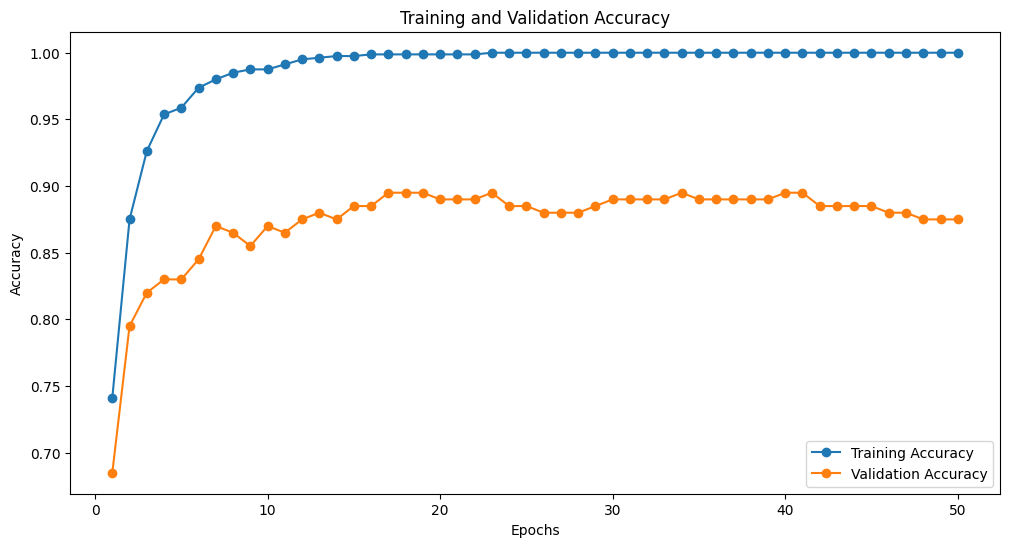

In [6]:
'''TODO: plot accuracy on train and validation set over epochs'''

epochs = range(1, len(history['accuracy']) + 1)

plt.figure(figsize=(12,6))

# Plotting training accuracy
plt.plot(epochs, history['accuracy'], label='Training Accuracy', marker='o')

# Plotting validation accuracy
plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', marker='o')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## B) Neural Network Classifier using PyTorch

### Data

In [127]:
# Define data preprocessing steps
transform = tv.transforms.Compose([
                tv.transforms.ToTensor(),
                tv.transforms.Normalize((0.5,), (0.5,))
            ])

# Download MNIST dataset
train_set = tv.datasets.MNIST('data', train=True, download=True, transform=transform)
val_set = tv.datasets.MNIST('data', train=False, download=True, transform=transform)

# Use only small subset of data for faster training
train_set = torch.utils.data.Subset(train_set, range(1000))
val_set = torch.utils.data.Subset(val_set, range(1000))

# Utilize PyTorch DataLoader from simplified & harmonized loading of data
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1)


### ML Model & Training

In [128]:
# Copy of model from network_pytorch.py

class NeuralNetworkTorch(nn.Module):
    def __init__(self, sizes, epochs=10, learning_rate=0.01, random_state=1):
       
        super().__init__()

        self.epochs = epochs
        self.learning_rate = learning_rate
        self.random_state = random_state   
        torch.manual_seed(self.random_state)

        '''
        TODO: Implement the forward propagation algorithm.
        The layers should be initialized according to the sizes variable.
        The layers should be implemented using variable size analogously to
        the implementation in network_pytorch: sizes[i] is the shape 
        of the input that gets multiplied to the weights for the layer.
        '''
        self.layers = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.layers.append(nn.Linear(sizes[i], sizes[i + 1]))

        self.activation_func = torch.sigmoid
        # No need to specify an activation function for the ouput layer given 
        # nn.CrossEntropyLoss applies softmax internally.
        #self.output_func = torch.softmax 
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=learning_rate)

        
    def _forward_pass(self, x_train):
        '''
        TODO: The method should return the output of the network.
        '''
        for layer in self.layers[:-1]:
            x_train = self.activation_func(layer(x_train))
        return self.layers[-1](x_train)




    def _backward_pass(self, y_train, output):
        '''
        TODO: Implement the backpropagation algorithm responsible for updating the weights of the neural network.
        '''
        loss = self.loss_func(output, y_train)  # Assuming y_train is of type torch.long
        loss.backward()




    def _update_weights(self):
        '''
        TODO: Update the network weights according to stochastic gradient descent.
        '''
        self.optimizer.step()


    def _flatten(self, x):
        return x.view(x.size(0), -1)       


    def _print_learning_progress(self, start_time, iteration, train_loader, val_loader):
        train_accuracy = self.compute_accuracy(train_loader)
        val_accuracy = self.compute_accuracy(val_loader)
        print(
            f'Epoch: {iteration + 1}, ' \
            f'Training Time: {time.time() - start_time:.2f}s, ' \
            f'Learning Rate: {self.optimizer.param_groups[0]["lr"]}, ' \
            f'Training Accuracy: {train_accuracy * 100:.2f}%, ' \
            f'Validation Accuracy: {val_accuracy * 100:.2f}%'
            )
        return train_accuracy, val_accuracy


    def predict(self, x):
        '''
        TODO: Implement the prediction making of the network.
        The method should return the index of the most likeliest output class.
        '''
        x = self._flatten(x)
        output = self._forward_pass(x)
        return torch.argmax(output, dim=1)



    def fit(self, train_loader, val_loader):
        start_time = time.time()
        history = {'accuracy': [], 'val_accuracy': []} 

        for iteration in range(self.epochs): 
            for x, y in train_loader:
                x = self._flatten(x)
                #y = nn.functional.one_hot(y, 10)
                self.optimizer.zero_grad()

                output = self._forward_pass(x) 
                self._backward_pass(y, output)
                self._update_weights()

            train_accuracy, val_accuracy = self._print_learning_progress(start_time, iteration, train_loader, val_loader)
            history['accuracy'].append(train_accuracy)
            history['val_accuracy'].append(val_accuracy)

        return history



    def compute_accuracy(self, data_loader):
        correct = 0
        for x, y in data_loader:
            pred = self.predict(x)
            correct += torch.sum(torch.eq(pred, y))

        return correct / len(data_loader.dataset)


In [129]:
#Adapted learning rate because it was overshooting
model = NeuralNetworkTorch(sizes=[784, 2**7, 2**6, 10], learning_rate=1.5, epochs=50, random_state=GLOBAL_RANDOM_STATE)
history_torch = model.fit(train_loader, val_loader)

model2 = NeuralNetworkTorch(sizes=[784, 2**7, 2**6, 10], learning_rate=0.02, epochs=50, random_state=GLOBAL_RANDOM_STATE)
history_torch2 = model2.fit(train_loader, val_loader)

Epoch: 1, Training Time: 2.18s, Learning Rate: 1.5, Training Accuracy: 9.40%, Validation Accuracy: 8.70%
Epoch: 2, Training Time: 4.29s, Learning Rate: 1.5, Training Accuracy: 9.40%, Validation Accuracy: 8.70%
Epoch: 3, Training Time: 6.26s, Learning Rate: 1.5, Training Accuracy: 9.40%, Validation Accuracy: 8.70%
Epoch: 4, Training Time: 8.22s, Learning Rate: 1.5, Training Accuracy: 9.40%, Validation Accuracy: 8.70%
Epoch: 5, Training Time: 10.23s, Learning Rate: 1.5, Training Accuracy: 9.40%, Validation Accuracy: 8.70%
Epoch: 6, Training Time: 12.23s, Learning Rate: 1.5, Training Accuracy: 9.40%, Validation Accuracy: 8.70%
Epoch: 7, Training Time: 14.24s, Learning Rate: 1.5, Training Accuracy: 9.40%, Validation Accuracy: 8.70%
Epoch: 8, Training Time: 16.29s, Learning Rate: 1.5, Training Accuracy: 9.40%, Validation Accuracy: 8.70%
Epoch: 9, Training Time: 18.38s, Learning Rate: 1.5, Training Accuracy: 9.40%, Validation Accuracy: 8.70%
Epoch: 10, Training Time: 20.56s, Learning Rate: 1

### Evaluation

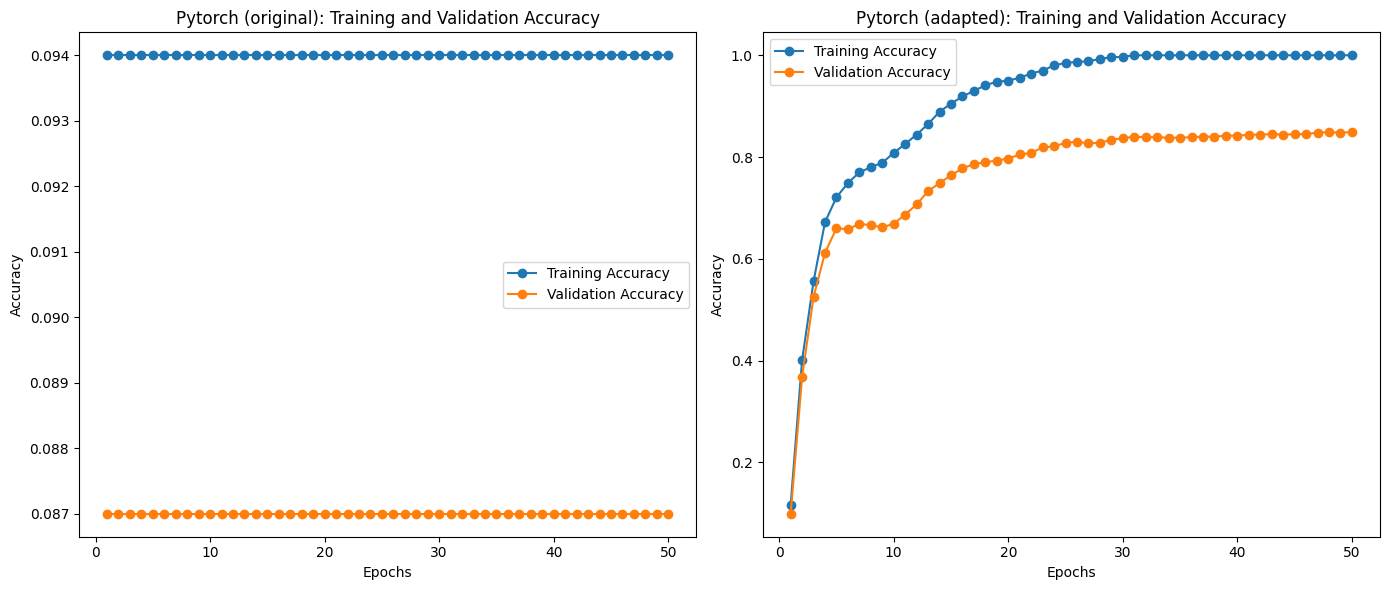

In [130]:
'''TODO: plot accuracy on train and validation set over epochs'''


epochs = range(1, len(history_torch['accuracy']) + 1)
epochs2 = range(1, len(history_torch2['accuracy']) + 1)

plt.figure(figsize=(14,6))

# First subplot for history_torch
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot

# Plotting training accuracy
plt.plot(epochs, history_torch['accuracy'], label='Training Accuracy', marker='o')

# Plotting validation accuracy
plt.plot(epochs, history_torch['val_accuracy'], label='Validation Accuracy', marker='o')

plt.title('Pytorch (original): Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Second subplot for history_torch2
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot

# Plotting training accuracy
plt.plot(epochs2, history_torch2['accuracy'], label='Training Accuracy', marker='o')

# Plotting validation accuracy
plt.plot(epochs2, history_torch2['val_accuracy'], label='Validation Accuracy', marker='o')

plt.title('Pytorch (adapted): Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



## C) Neural Network Classifier using Keras

### Data

In [102]:
# Download MNIST dataset
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

# Preprocess dataset
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)

# Use only small subset of data for faster training

x_train = x_train[:1000]
y_train = y_train[:1000]

x_val = x_val[:1000]
y_val = y_val[:1000]


### ML Model & Training

In [123]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)



class NeuralNetworkTf(tf.keras.Sequential):

  def __init__(self, sizes, random_state=1):
    
    super().__init__()
    self.sizes = sizes
    self.random_state = random_state
    tf.random.set_seed(random_state)
    
    # error 1: flatten the input data since its a fully connected network
    self.add(tf.keras.layers.Flatten(input_shape=(28,28)))

    for i in range(0, len(sizes)):
      # error 2: correctyed looping condition, use softmax solely at the output layer, use sigmoid for all hidden layers
      if i == len(sizes) - 1:
        self.add(tf.keras.layers.Dense(sizes[i], activation='softmax'))
        
      else:
        self.add(tf.keras.layers.Dense(sizes[i], activation='sigmoid')) # FYI: Using relu here improves the validation accuracy enourmously
      
        
  
  def compile_and_fit(self, x_train, y_train, 
                      epochs=50, learning_rate=0.01, 
                      batch_size=1,validation_data=None):
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    # error 3: used multi-class crossentropy given we are solving a multiclass problem
    loss_function = tf.keras.losses.CategoricalCrossentropy()
    eval_metrics = ['accuracy']

    super().compile(optimizer=optimizer, loss=loss_function, 
                    metrics=eval_metrics)
    return super().fit(x_train, y_train, epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=validation_data)  



class TimeBasedLearningRate(tf.keras.optimizers.schedules.LearningRateSchedule):
  '''
  TODO: Implement a time-based learning rate that takes as input a 
  positive integer (initial_learning_rate) and at each step reduces the
  learning rate by 1 until minimal learning rate of 1 is reached.
  '''

  def __init__(self, initial_learning_rate, decay_step=1, min_learning_rate=1):

    super(TimeBasedLearningRate, self).__init__()
    self.initial_learning_rate = initial_learning_rate
    self.decay_step = tf.cast(decay_step, dtype=tf.float32) # cast decay step to float
    self.min_learning_rate = min_learning_rate


  def __call__(self, step):

    step = tf.cast(step, dtype=tf.float32) # ensure the step is float
    learning_rate = tf.maximum(self.min_learning_rate, 
                               self.initial_learning_rate - self.decay_step * step)
    return learning_rate



In [124]:
model_tf = NeuralNetworkTf(sizes=[784, 2**7, 2**5, 10])
tb_learning_rate = TimeBasedLearningRate(10)

#Adapted learning rate because it was overshooting
model_tf2 = NeuralNetworkTf(sizes=[128, 64, 10])
tb_learning_rate2 = TimeBasedLearningRate(0.02, decay_step = 0.001, min_learning_rate=0.01)

In [ ]:
#print(y_train[:10])

In [125]:
history_tf = model_tf.compile_and_fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, learning_rate=tb_learning_rate, batch_size=1)

# Version with learning rate to limit overshooting and larger batch size as the old one was very small and led to fluctuations in val accuracy
history_tf2 = model_tf2.compile_and_fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, learning_rate=tb_learning_rate2, batch_size=32)

Epoch 1/50
   1/1000 [..............................] - ETA: 1:47 - loss: 2.3648 - accuracy: 0.0000e+00

c:\Users\kaius\.virtualenvs\ML_Lab_1_Group-A-YrkWYMVn\lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1000/1000 [==============================] - 35s 35ms/step - loss: 5.8307 - accuracy: 0.0940 - val_loss: 3.3812 - val_accuracy: 0.0890
Epoch 2/50
1000/1000 [==============================] - 36s 36ms/step - loss: 3.5531 - accuracy: 0.1120 - val_loss: 3.5395 - val_accuracy: 0.0870
Epoch 3/50
1000/1000 [==============================] - 36s 36ms/step - loss: 3.1959 - accuracy: 0.1040 - val_loss: 3.2863 - val_accuracy: 0.0870
Epoch 4/50
1000/1000 [==============================] - 35s 35ms/step - loss: 3.2088 - accuracy: 0.0940 - val_loss: 3.2727 - val_accuracy: 0.0940
Epoch 5/50
1000/1000 [==============================] - 34s 34ms/step - loss: 3.1833 - accuracy: 0.1070 - val_loss: 2.4883 - val_accuracy: 0.1100
Epoch 6/50
1000/1000 [==============================] - 34s 34ms/step - loss: 3.1913 - accuracy: 0.1080 - val_loss: 2.8794 - val_accuracy: 0.1100
Epoch 7/50
1000/1000 [==============================] - 34s 34ms/step - loss: 3.1982 - accuracy: 0.1030 - val_loss: 3.8568 - val_accura

### Evaluation

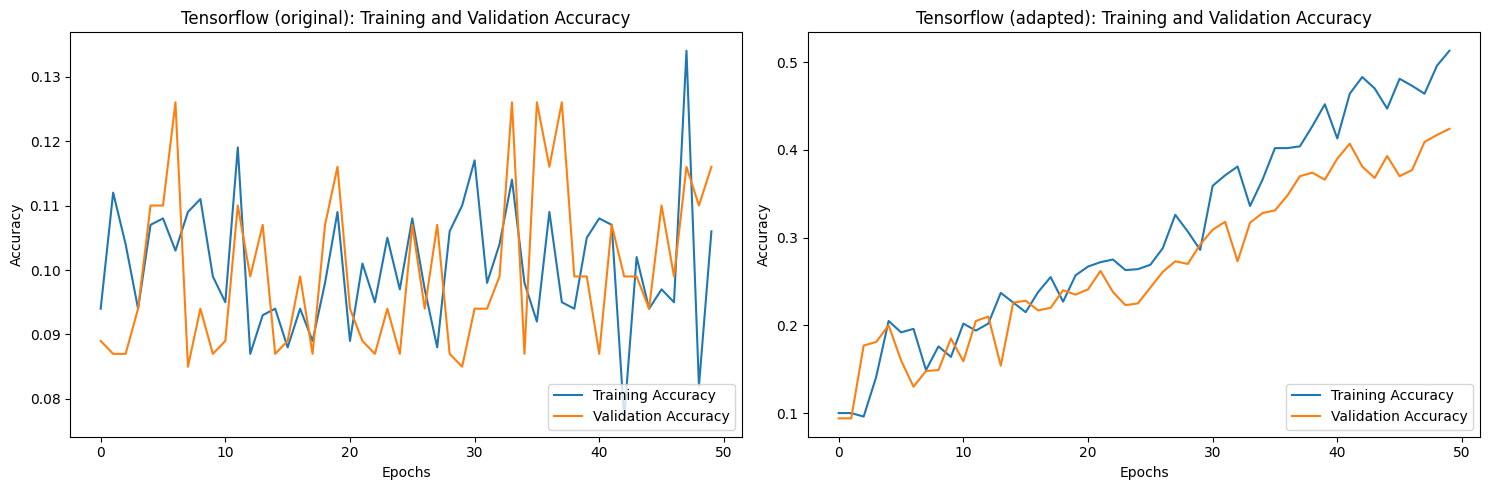

In [135]:
'''TODO: plot accuracy on train and validation set over epochs'''

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot history_tf
axes[0].plot(history_tf.history['accuracy'], label='Training Accuracy')
axes[0].plot(history_tf.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Tensorflow (original): Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')

# Plot history_tf2
axes[1].plot(history_tf2.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_tf2.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Tensorflow (adapted): Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()


NOTE: We recognise the limitation in the tensorflow model that we are undershooting even in the adapted model. Within the scope of the time we had, we decised to stop further tuning the hyperparameters for a model using sigmoid activation functions. A tensorflow model using a relu activation function (everything else equal in terms of hyperparameters in the adapted model) would lead to a model that performs well at about 80% accuracy and would be neither under- nor overshooting. 